## Remember to use MOU conda environment

In [1]:
# numpy and scipy
import numpy as np
import scipy.linalg as spl
import scipy.signal as spsg
import scipy.io as sio
import scipy.stats as stats

# MOU model
from test_MOU_largenet import MOUv2

# classification scikit-learn
import sklearn.linear_model as skllm
import sklearn.preprocessing as skppr
import sklearn.pipeline as skppl
import sklearn.neighbors as sklnn

# plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sb
import pandas as pd

#statistical tests
import scipy.stats as stats

#importing ENIGMA
from enigmatoolbox.datasets import load_sc_as_one
from nilearn import plotting

In [2]:
data_dir = './' # data repo
res_dir = './' # results
graph_format = 'png' # graph formatting

conds = ['CTR', 'SCZ'] #conditions
 # number of conditions

# 68 is the number of brain regions
N = 68 # size of network for DK-68 

In [8]:
#NB: ./ = prendi il path
ts_ctr = sio.loadmat('./ts_ctr.mat')['ts_ctr'] 
ts_ctr=ts_ctr[0:68,:,20:68]
ts_scz = sio.loadmat('./ts_scz.mat')['ts_scz']
ts_scz=ts_scz[0:68]
ts_all = np.stack((ts_ctr, ts_scz), axis=-1)

ts_all.shape
#68 = brain regions
#48 = patients
#152 = time (?)
#2 = ctr, scz = conditions

(68, 152, 48, 2)

# Model optimization

## NEW TASKS
1. Evaluate godness of fit changing the percentile, 70% (try 50/60/80/90) -> plot all of them to compare 
2. try a combination of FC0 and FC1 -> how to sum two binary matrix 
3. Try with connectome too
4. Good fitting and differences of entropy production

NB. Look at the paper for MOU and LC references
Book at page 112 (not for now)



## Comparison using different MASKS

1. Comparison for different percentages, but using FC0 mask

In [ ]:
import numpy as np
import scipy.signal as spsg
from scipy import stats
from scipy.linalg import solve_lyapunov as spl

# Assuming MOUv2 is a defined class elsewhere
# from your_library import MOUv2 

# Data and model parameters
subjects = np.arange(1, 48)
n_sub = len(subjects)
N = 68

mask_Sigma = np.eye(N, dtype=bool)
conds = ['CTR', 'SCZ']
n_cond = len(conds)

# Arrays to store results
var_BOLD = np.zeros([n_sub, n_cond, N])
FC0p_list = [50, 60, 70, 80, 90]
FC1p_list = [40, 50, 60, 70, 80]
n_p = len(FC0p_list)

J_mods = {i_p: np.zeros([n_sub, n_cond, N, N]) for i_p in range(n_p)}
Sigma_mods = {i_p: np.zeros([n_sub, n_cond, N, N]) for i_p in range(n_p)}
FC0_mods = {i_p: np.zeros([n_sub, n_cond, N, N]) for i_p in range(n_p)}
err_mods = {i_p: np.zeros([n_sub, n_cond]) for i_p in range(n_p)}
fit_mods = {i_p: np.zeros([n_sub, n_cond]) for i_p in range(n_p)}

# Filter design
n_order = 3
TR = 2  # in seconds
Nyquist_freq = 0.5 / TR
low_f = 0.001 / Nyquist_freq
high_f = 0.01 / Nyquist_freq
b, a = spsg.iirfilter(n_order, [low_f, high_f], btype='bandpass', ftype='butter')

# Function for empirical correlations MASKS
def mask(FC0p, FC1p, ts_all, i_sub, i_cond):
    ts3 = ts_all[0:68, :, i_sub, i_cond]
    filt_ts = spsg.filtfilt(b, a, ts3, axis=1)
    ts = stats.zscore(filt_ts, axis=1)
    
    # Store empirical BOLD variance
    var_BOLD[i_sub, i_cond, :] = ts.var(axis=1)
    
    FC0 = np.tensordot(ts[:, :-1], ts[:, :-1], axes=(1, 1)) / ts.shape[1]
    FC1 = np.tensordot(ts[:, :-1], ts[:, 1:], axes=(1, 1)) / ts.shape[1]
    FC0N = np.abs(FC0) / np.max(np.abs(FC0))
    FC1N = np.abs(FC1) / np.max(np.abs(FC1))
    
    lim_FC0 = np.percentile(FC0N, FC0p)
    lim_FC1 = np.percentile(FC1N, FC1p)

    mask_EC1 = FC0N > lim_FC0
    np.fill_diagonal(mask_EC1, True)
    
    mask_EC2 = FC1N > lim_FC1
    np.fill_diagonal(mask_EC2, False)
    
    return mask_EC1

# Loop over subjects, conditions, and parameters
for i_sub in range(n_sub):
    print(f"Sub {i_sub+1}/{n_sub}")
    for i_cond in range(n_cond):
        for i_p in range(n_p):
            mask_EC = mask(FC0p_list[i_p], FC1p_list[i_p], ts_all, i_sub, i_cond)
            
            # Invert model
            mou_est = MOUv2()
            fit_res = mou_est.fit(
                ts_all[:, :, i_sub, i_cond].T,
                mask_C=mask_EC,
                mask_Sigma=mask_Sigma,
                algo_version='true',
                min_iter=100,
                epsilon_C=0.005,
                epsilon_Sigma=0.005,
            )
            
            # Store results
            J_mods[i_p][i_sub, i_cond, :, :] = fit_res.J
            Sigma_mods[i_p][i_sub, i_cond, :, :] = fit_res.Sigma
            FC0_mods[i_p][i_sub, i_cond, :, :] = spl(
                J_mods[i_p][i_sub, i_cond, :, :].T,
                -Sigma_mods[i_p][i_sub, i_cond, :, :]
            )
            err_mods[i_p][i_sub, i_cond] = fit_res.d_fit['distance']
            fit_mods[i_p][i_sub, i_cond] = fit_res.d_fit['correlation']


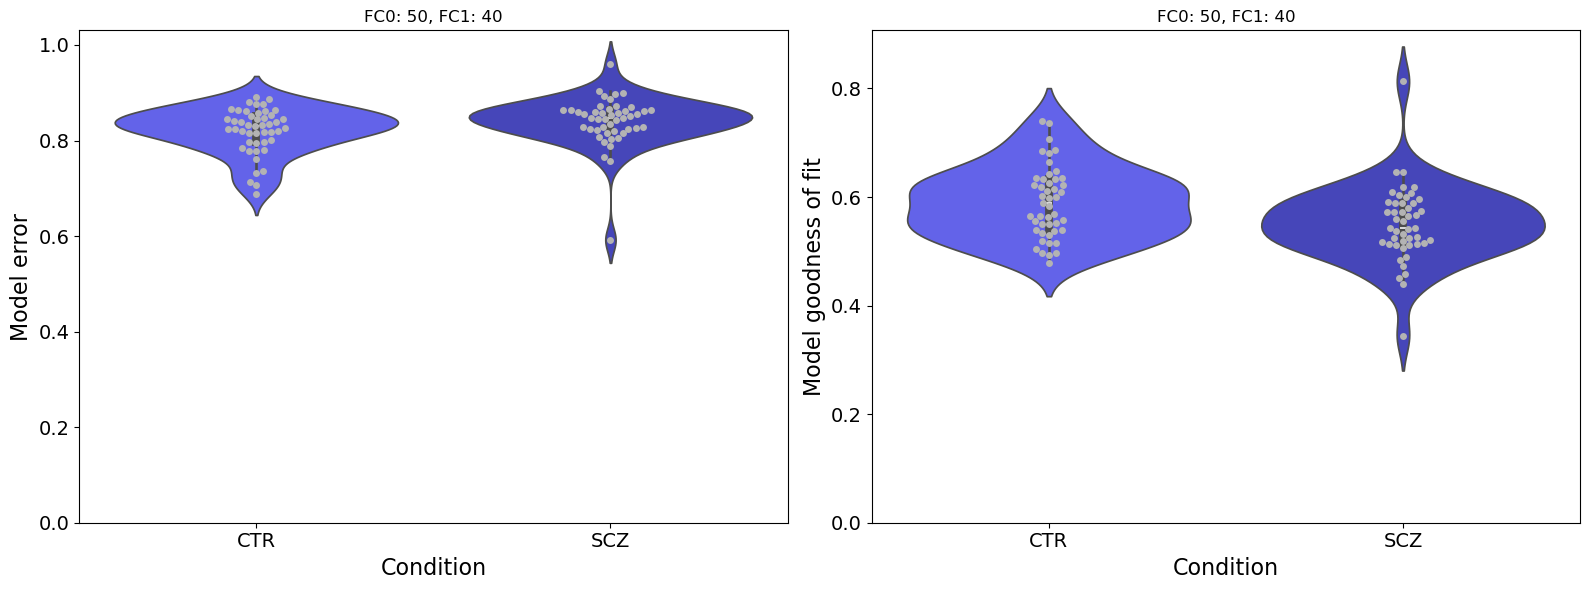

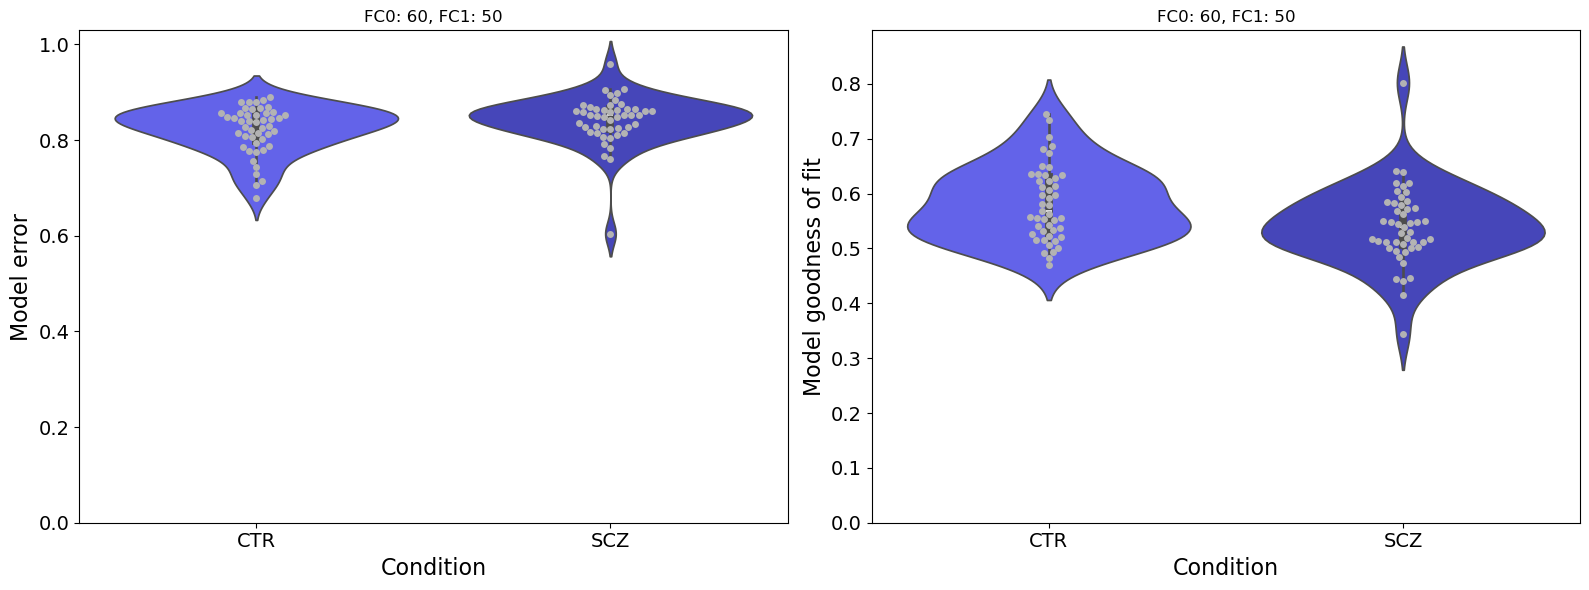

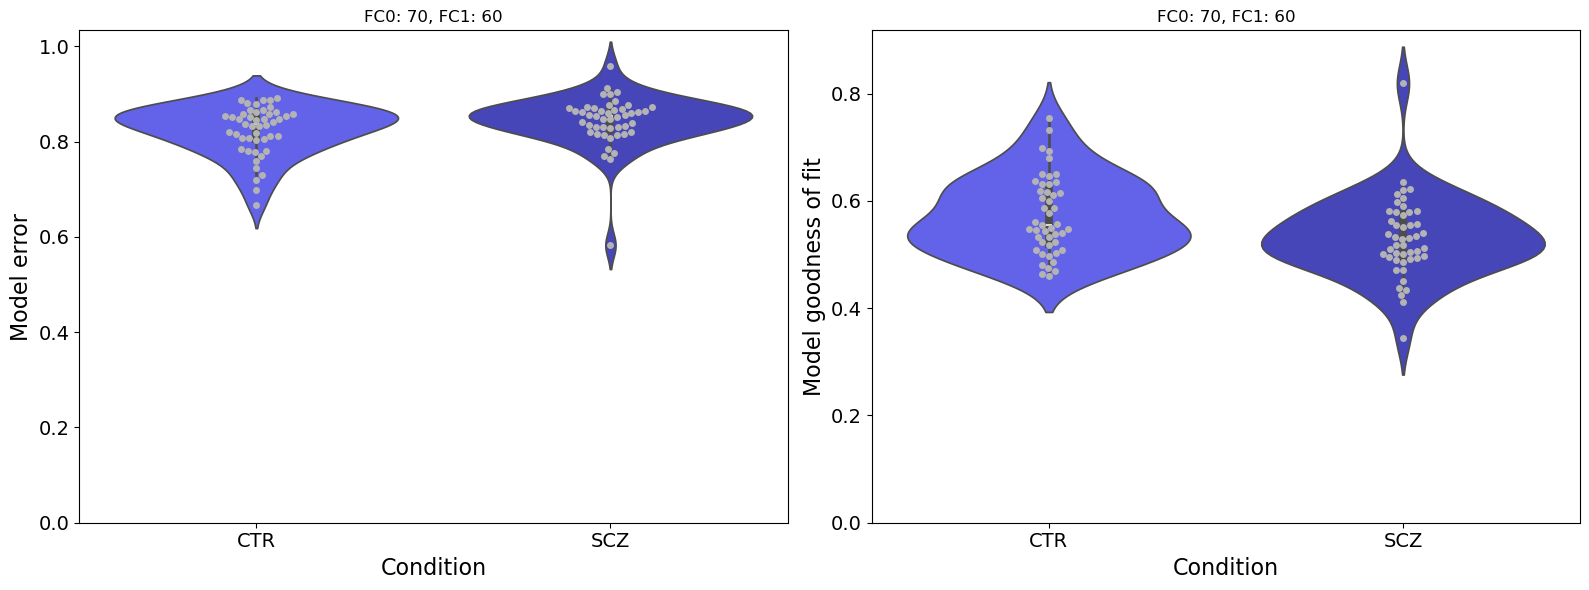

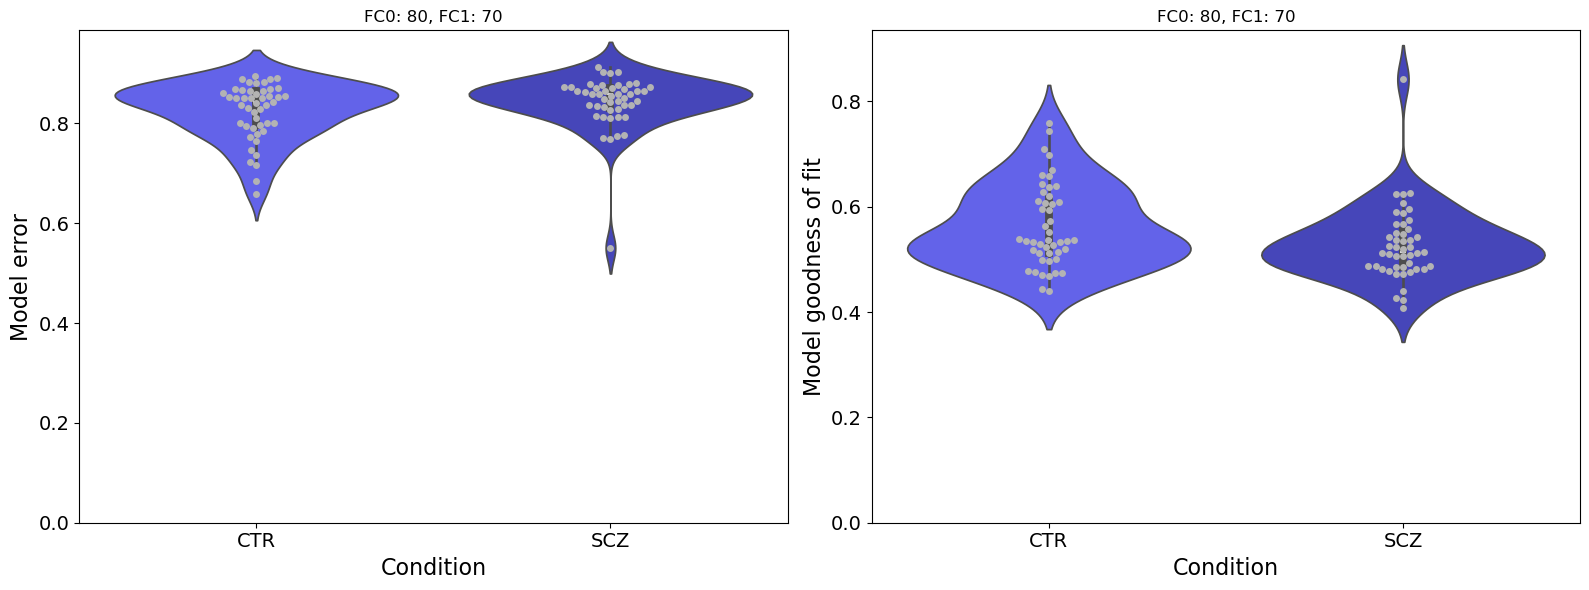

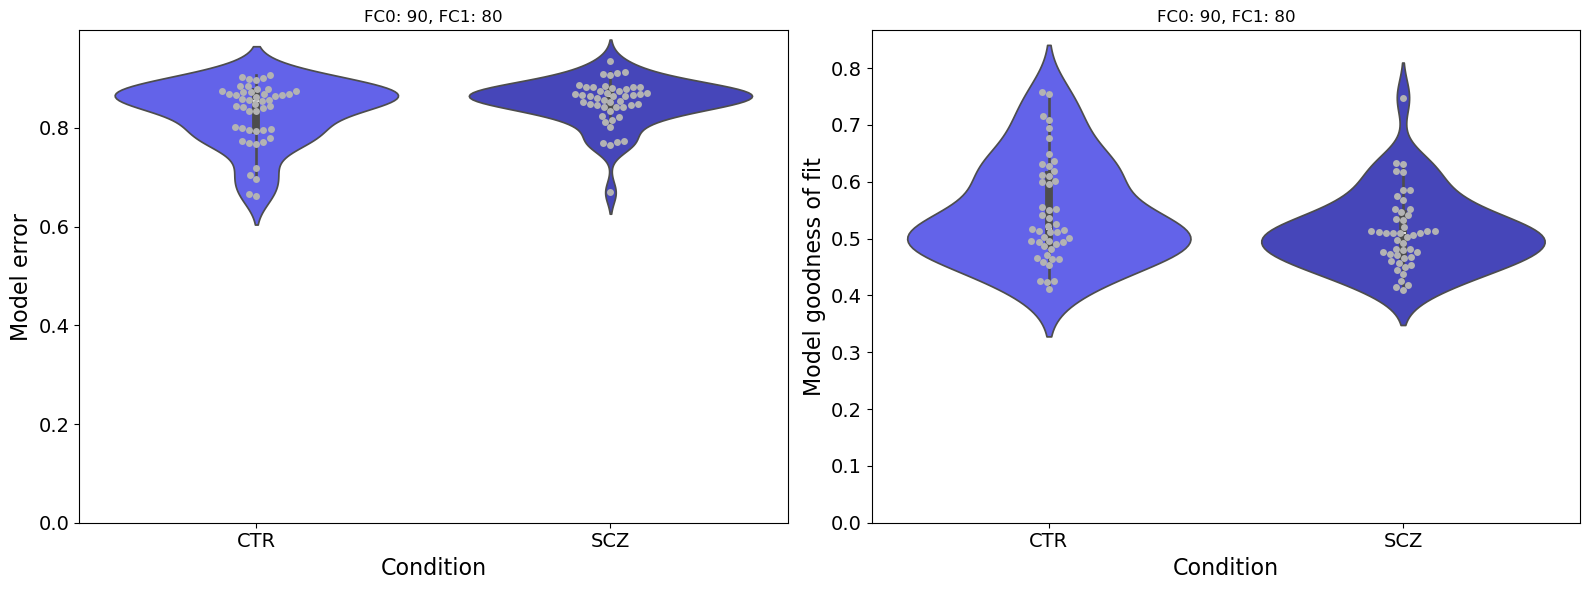

In [46]:
#to improve graphs visibility
import warnings
warnings.filterwarnings("ignore")

#plot graphs
def fit_goodness(err_mod, fit_mod):
    mask_diag = np.eye(N, dtype=bool) # mask for diagonal elements
    n_cond=2

    cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]] # colors

    # model error

    err_mod_tmp = dict()
    err_mod_tmp['sum EC'] = err_mod.flatten()
    err_mod_tmp['sub'] = np.repeat(np.arange(n_sub), n_cond).flatten()
    err_mod_tmp['cond'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()

    err_mod_df = pd.DataFrame(err_mod_tmp)

    plt.figure(figsize=(16,6))
    plt.subplot(1, 2, 1)
    sb.violinplot(data=err_mod_df, x='cond', y='sum EC', palette=cols)
    sb.swarmplot(data=err_mod_df, x='cond', y='sum EC', color=[0.7,0.7,0.7])
    plt.axis(ymin=0)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Condition',fontsize=16)
    plt.ylabel('Model error',fontsize=16)
    plt.title(f'FC0: {FC0p_list[i_p]}, FC1: {FC1p_list[i_p]}')

    plt.tight_layout()
    #plt.savefig(res_dir+'model_fit_error.eps', format='eps')


    # Pearson corr

    fit_mod_tmp = dict()
    fit_mod_tmp['sum EC'] = fit_mod.flatten()
    fit_mod_tmp['sub'] = np.repeat(np.arange(n_sub), n_cond).flatten()
    fit_mod_tmp['cond'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()

    fit_mod_df = pd.DataFrame(fit_mod_tmp)

    plt.subplot(1, 2, 2)
    sb.violinplot(data=fit_mod_df, x='cond', y='sum EC', palette=cols)
    sb.swarmplot(data=fit_mod_df, x='cond', y='sum EC', color=[0.7,0.7,0.7])
    plt.axis(ymin=0)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Condition',fontsize=16)
    plt.ylabel('Model goodness of fit',fontsize=16)
    plt.title(f'FC0: {FC0p_list[i_p]}, FC1: {FC1p_list[i_p]}')

    plt.tight_layout()
    plt.show()
    #plt.savefig(res_dir+'model_goodness_fit.eps', format='eps')

for i_p in range(n_p):
    fit_goodness(err_mods[i_p], fit_mods[i_p])



# Checking ENTROPY PRODUCTION rate: 

In [59]:
# transpose to Saclay's framework
EPR = {i_p: np.zeros([n_sub, n_cond]) for i_p in range(n_p)}
Q_indiv = {i_p: np.zeros([n_sub, n_cond, N, N]) for i_p in range(n_p)}

for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        for i_p in range(n_p):
            try:
                B = np.copy(-J_mods[i_p][i_sub,i_cond,:,:].T)
                D = np.copy(0.5 * Sigma_mods[i_p][i_sub,i_cond,:,:])
                S = np.copy(FC0_mods[i_p][i_sub,i_cond,:,:])
                
                Q = np.dot(B, S) - D
                Q_indiv[i_p][i_sub,i_cond,:,:] = Q
                
                # sanity check
                if True:
                    print('should be close to zero:', np.abs(np.dot(B,S) + np.dot(S,B.T) -2*D).max())
            
                # formula from Godreche Luck
                Dinv = np.linalg.pinv(D)
                Sinv = np.linalg.pinv(S)
                
                entropy_prod_rate = -np.trace(np.dot(np.dot(np.dot(Sinv, Q), Dinv), Q))
                EPR[i_p][i_sub,i_cond] = entropy_prod_rate

            except:
                print('problem with subject/cond:', i_sub, i_cond)


should be close to zero: 3.6193270602780103e-14
should be close to zero: 7.460698725481052e-14
should be close to zero: 4.796163466380676e-14
should be close to zero: 1.9184653865522705e-13
should be close to zero: 6.039613253960852e-14
should be close to zero: 8.881784197001252e-14
should be close to zero: 7.155907810751927e-14
should be close to zero: 1.3500311979441904e-13
should be close to zero: 8.526512829121202e-14
should be close to zero: 1.4921397450962104e-13
should be close to zero: 7.105427357601002e-14
should be close to zero: 5.1236792586450974e-14
should be close to zero: 1.5631940186722204e-13
should be close to zero: 1.1368683772161603e-13
should be close to zero: 1.0746958878371515e-13
should be close to zero: 3.979039320256561e-13
should be close to zero: 4.547473508864641e-13
should be close to zero: 7.105427357601002e-13
should be close to zero: 3.2729374765949615e-13
should be close to zero: 4.831690603168681e-13
should be close to zero: 9.592326932761353e-14
shou

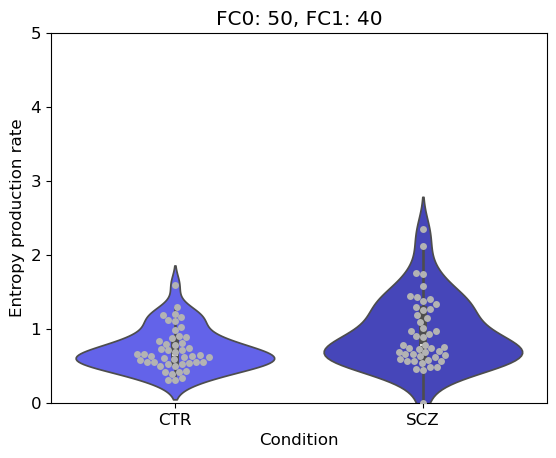

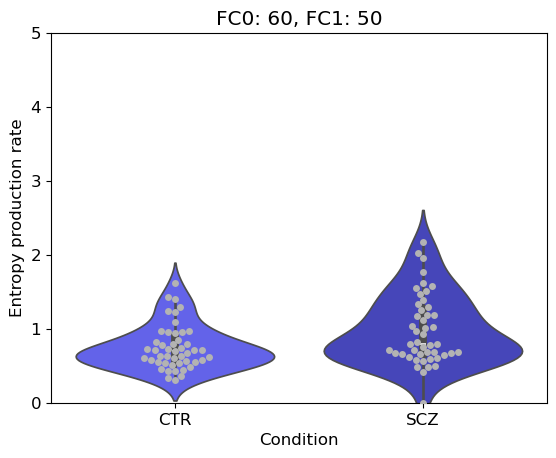

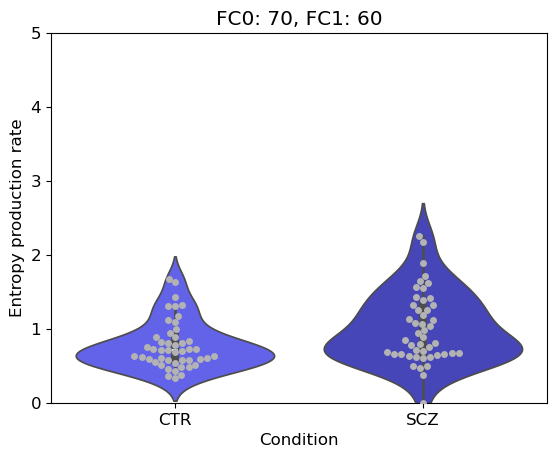

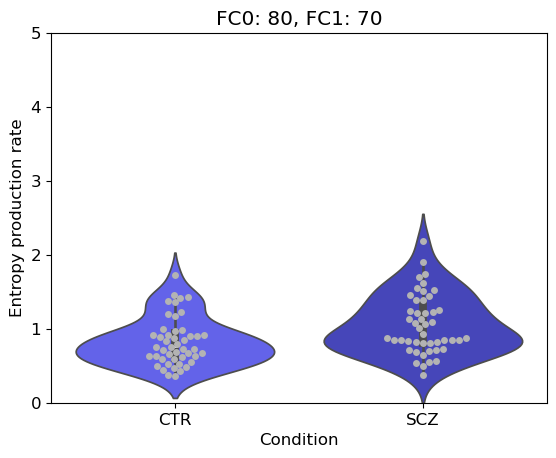

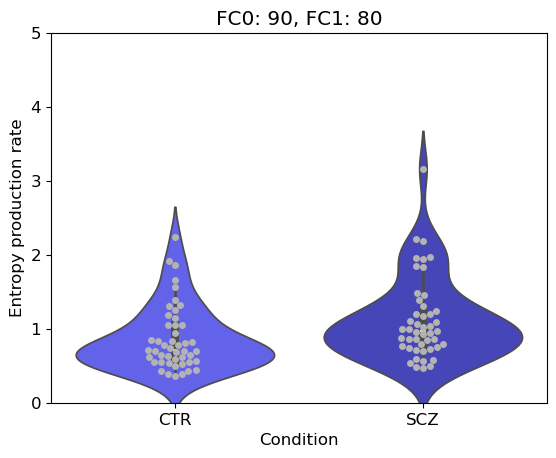

In [54]:
#%% plots
def EPR_plot(EPR):
    matplotlib.rc('font', size=12) 
    matplotlib.rc('xtick', labelsize=12)
    matplotlib.rc('ytick', labelsize=12)

    cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]]
    cols2 = [[0.7,0.7,1],[0.6,0.6,1],[0.5,0.5,1],[0.4,0.4,1]]

    EPR_tmp = dict()
    EPR_tmp['conditions'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()
    EPR_tmp['EPR'] = EPR.flatten()

    EPR_df = pd.DataFrame(EPR_tmp)


    # real data

    plt.figure()
    ax = sb.violinplot(data=EPR_df, x='conditions', y='EPR', palette=cols)
    sb.swarmplot(data=EPR_df, x='conditions', y='EPR', color=[0.7,0.7,0.7])
    plt.axis(ymin=0, ymax=5)

    plt.xlabel('Condition', fontsize=12)
    plt.ylabel('Entropy production rate', fontsize=12)
    plt.title(f'FC0: {FC0p_list[i_p]}, FC1: {FC1p_list[i_p]}')
    plt.show()

for i_p in range(n_p):
    EPR_plot(EPR[i_p])
#plt.savefig(res_dir+'entropy_prod_rate.eps', format='eps')

In [56]:
#Check if they are statistically independent
for i_p in range(n_p):
    CTR = EPR[i_p][:,0]
    SCZ = EPR[i_p][:,1]
    stat_t, p_t = stats.ttest_ind(CTR, SCZ, equal_var=False)

    print(f"Welch's t-test statistic: {stat_t:.3f}, p-value: {p_t:.3f}")

    if p_t < 0.05:
        print("The difference between groups is statistically significant.")
    else:
        print("No significant difference between groups.")

Welch's t-test statistic: -2.882, p-value: 0.005
The difference between groups is statistically significant.
Welch's t-test statistic: -2.843, p-value: 0.006
The difference between groups is statistically significant.
Welch's t-test statistic: -2.780, p-value: 0.007
The difference between groups is statistically significant.
Welch's t-test statistic: -3.102, p-value: 0.003
The difference between groups is statistically significant.
Welch's t-test statistic: -2.452, p-value: 0.016
The difference between groups is statistically significant.
